In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from fastprogress.fastprogress import master_bar, progress_bar
from torchvision.transforms.functional import to_grayscale
from sklearn.metrics import accuracy_score, roc_auc_score
from torchvision.utils import make_grid
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ff21c6128b5ae4b4bcd63fa56da6d8c9e2fd56ffec0e0f5888504949d2ef0234
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
normal = Path('../input/surface-crack-detection/Negative')
cracks = Path('../input/surface-crack-detection/Positive')

train_data = [(o,0) for o in normal.iterdir()]
train_data_cracks = [(o,1) for o in cracks.iterdir()]
train_data.extend(train_data_cracks)

train_data = pd.DataFrame(train_data, columns=["filepath","cracks"])
train_data.head()

,filepath,cracks
0,../input/surface-crack-detection/Negative/0845...,0
1,../input/surface-crack-detection/Negative/1981...,0
2,../input/surface-crack-detection/Negative/1691...,0
3,../input/surface-crack-detection/Negative/0593...,0
4,../input/surface-crack-detection/Negative/0612...,0


In [3]:
bs = 64
lr=1e-5
wd=0.01

In [4]:
np.random.seed(42)
msk = np.random.rand(len(train_data)) < 0.9
print(msk)

train_df = train_data[msk].reset_index()
val_df = train_data[~msk].reset_index()

[ True False  True ...  True  True  True]


In [5]:
class surfdataset(Dataset):
    def __init__(self,df,transforms=None,is_test=False):
        self.df=df
        self.transforms=transforms
        self.is_test= is_test
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self,idx):
        img=Image.open(self.df.iloc[idx]['filepath'])
        if self.transforms:
            img= self.transforms(**{'image':np.array(img)})['image']
        if self.is_test:
            return img
        else:
            cracks_tensor=torch.tensor([self.df.iloc[idx]['cracks']],dtype=torch.float32)
            return img,cracks_tensor

In [6]:
train_tfms = A.Compose([
    A.Cutout(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
        ])
    
test_tfms = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
        ])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [7]:
train_ds = surfdataset(train_df, transforms=train_tfms)
val_ds = surfdataset(val_df, transforms=test_tfms, is_test=True)
len(train_ds), len(val_ds)

(36016, 3984)

In [8]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=128, 
                    num_workers=2, pin_memory=True)

In [9]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([128, 3, 227, 227]), torch.Size([128, 1]))

In [10]:
class Crackdetector(nn.Module):
    def __init__(self,eff_name="efficientnet-b0", n_outs=1):
        super().__init__()
        self.backbone= EfficientNet.from_pretrained(eff_name)
        in_features= getattr(self.backbone,"_fc").in_features
        self.classifier= nn.Sequential(nn.Linear(in_features,in_features//2),
                                       nn.Dropout(p=0.2),
                                       nn.Linear(in_features//2,in_features//4),
                                       nn.Dropout(p=0.2),
                                       nn.Linear(in_features//4,n_outs)
                                      )
    def forward(self,input_of_model):
        out_before_classifier = self.backbone.extract_features(input_of_model)
        
        #to convert the 7x7 to 1x1 we use a adaptive average pool 2d
        pool_output = F.adaptive_avg_pool2d(out_before_classifier, 1)
        classifier_in = pool_output.view(pool_output.size(0),-1)
        classifier_out = self.classifier(classifier_in)
        return classifier_out

In [11]:
def get_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def get_model(model_name='efficientnet-b0',lr=1e-5,wd=0.01,freeze_backbone=False,opt_fn=torch.optim.AdamW,device=None):
    device = device if device else get_device()
    model = Crackdetector(eff_name=model_name)
    if freeze_backbone:
        for parameter in model.backbone.parameters():
            parameter.requires_grad = False
    opt = opt_fn(model.parameters(),lr=lr,weight_decay=wd)
    model = model.to(device)
    return model, opt

def training_step(xb,yb,model,loss_fn,opt,device,scheduler):
    xb,yb = xb.to(device), yb.to(device)
    out = model(xb)
    opt.zero_grad()
    loss = loss_fn(out,yb)
    loss.backward()
    opt.step()
    scheduler.step()
    return loss.item()
    
def validation_step(xb,yb,model,loss_fn,device):
    xb,yb = xb.to(device), yb.to(device)
    out = model(xb)
    loss = loss_fn(out,yb)
    out = torch.sigmoid(out)
    return loss.item(),out
def get_data(train_df,valid_df,train_tfms,test_tfms,bs):
    train_ds = surfdataset(df=train_df,transforms=train_tfms)
    valid_ds = surfdataset(df=valid_df,transforms=test_tfms)
    train_dl = DataLoader(dataset=train_ds,batch_size=bs,shuffle=True,num_workers=4)
    valid_dl = DataLoader(dataset=valid_ds,batch_size=bs*2,shuffle=False,num_workers=4)
    return train_dl,valid_dl

In [12]:
def fit(epochs,model,train_dl,valid_dl,opt,device=None,loss_fn=F.binary_cross_entropy_with_logits):
    
    device = device if device else get_device()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs)
    val_rocs = []
    tloss = []
    vloss = []
    
    #Creating progress bar
    mb = master_bar(range(epochs))
    mb.write(['epoch','train_loss','valid_loss','val_roc'],table=True)

    for epoch in mb:    
        trn_loss,val_loss = 0.0,0.0
        val_preds = np.zeros((len(valid_dl.dataset),1))
        val_targs = np.zeros((len(valid_dl.dataset),1))
        
        #Training
        model.train()
        
        #For every batch 
        for xb,yb in progress_bar(train_dl,parent=mb):
            trn_loss += training_step(xb,yb,model,loss_fn,opt,device,scheduler) 
        trn_loss /= mb.child.total
        tloss.append(trn_loss)
        model.eval()
        with torch.no_grad():
            for i,(xb,yb) in enumerate(progress_bar(valid_dl,parent=mb)):
                loss,out = validation_step(xb,yb,model,loss_fn,device)
                val_loss += loss
                bs = xb.shape[0]
                val_preds[i*bs:i*bs+bs] = out.cpu().numpy()
                val_targs[i*bs:i*bs+bs] = yb.cpu().numpy()

        val_loss /= mb.child.total
        vloss.append(val_loss)
        val_roc = roc_auc_score(val_targs.reshape(-1),val_preds.reshape(-1))
        val_rocs.append(val_roc)

        mb.write([epoch,f'{trn_loss:.6f}',f'{val_loss:.6f}',f'{val_roc:.6f}'],table=True)
    return model,val_rocs, tloss, vloss

In [13]:
train_dl,valid_dl = get_data(train_df,val_df,train_tfms,test_tfms,bs)
model, opt = get_model(model_name='efficientnet-b0',lr=1e-4,wd=1e-4)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [14]:
model,val_rocs, train_loss, valid_loss = fit(10,model,train_dl,valid_dl,opt)

epoch,train_loss,valid_loss,val_roc
0,0.022553,0.005013,0.999906
1,0.003878,0.005239,0.999787
2,0.002431,0.006460,0.999769
3,0.002010,0.004517,0.999840
4,0.000877,0.005937,0.999792
5,0.000416,0.007507,0.999777
6,0.001156,0.005337,0.999770
7,0.000562,0.005634,0.999766
8,0.000331,0.005636,0.999765
9,0.000645,0.005677,0.999765


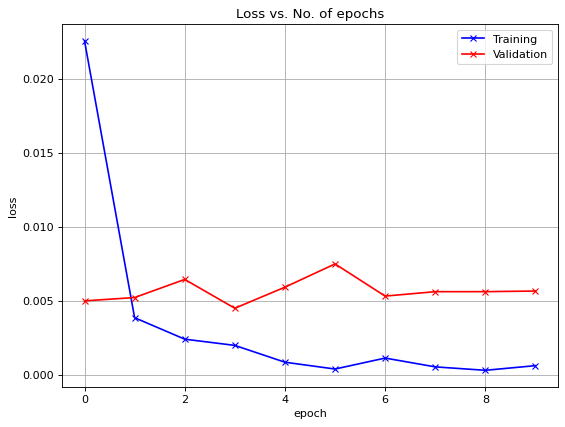

In [15]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, '-bx')
plt.plot(valid_loss, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');
plt.grid()